In [2]:
import os
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import TimeDistributed,LSTM,Dense,Flatten,Dropout,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from keras.applications.vgg16 import VGG16
from keras import  models

from batch_data_generator import DataGenerator

## 1. Global configs for all models

In [3]:
seed_constant = 123
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [4]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   try:
#     # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)

# print(tf.config.list_physical_devices('GPU'))
# if tf.config.list_physical_devices('GPU'):
#     print(tf.config.experimental.get_memory_info('GPU:0'))
#     print(tf.config.experimental.get_memory_info('GPU:1'))

print(tf.config.list_physical_devices('GPU'))
tf.config.experimental.get_memory_info('GPU:0')['current']

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


0

In [5]:
# Data paths are defined here
DATA_DIR = 'data'
VIDEO_PATH = os.path.join(DATA_DIR, 'videos')
ANNOTATION_PATH = os.path.join(DATA_DIR, 'annotations')
TRAINING_PATH = os.path.join(VIDEO_PATH, 'training')
TESTING_PATH = os.path.join(VIDEO_PATH, 'testing')
VALIDATION_PATH = os.path.join(VIDEO_PATH, 'validation')

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 30

# Set a minimum duration in seconds to extract sequence in multiples of
MIN_DURATION = 150

(DIMENSION_X, DIMENSION_Y, DIMENSION_C) = (224, 224, 3)

# Get the names of all classes/categories in our dataset.
CLASSES_LIST = os.listdir(TRAINING_PATH)


TRAINING_BATCH_SIZE = 5
VALIDATION_BATCH_SIZE = 5

NR_EPOCHS = 60
NR_WORKERS = 6


class_mapping = {
'_cut___chop___slice_a_vegetable,_fruit,_or_meat_' : 'cut vegetables, herbs or meat',
'browse_through_clothing_items_on_rack___shelf___hanger' : 'browse through clothing items',
'clean___wipe_other_surface_or_object' : 'clean surface',
'dig_or_till_the_soil_with_a_hoe_or_other_tool' : 'till soil with a hoe',
'read_a_book___magazine___shopping_list_etc' : 'read a book',
'throw_away_trash___put_trash_in_trash_can' : 'throw away trash',
'wash_dishes___utensils___bakeware_etc' : 'wash utensils'}

print(len(CLASSES_LIST))

7


In [6]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name,y_label='accuracy'):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))
    
    plt.xlabel('Epochs')
    plt.ylabel(y_label)

    # Add legend to the plot.
    plt.legend()


def get_nparray_and_labels_in_partition(partition_path):
    nparrayfile_paths = []
    labels = {}
    for class_name in os.listdir(partition_path):
        if class_name not in CLASSES_LIST:
            print(f'{class_name} not found in class list!')
            continue
        for video_file_name in os.listdir(os.path.join(partition_path, class_name)):
            if not video_file_name.endswith('.npy'): continue
            nparrayfile_path = os.path.join(partition_path, class_name, video_file_name)
            nparrayfile_paths.append(nparrayfile_path)
            labels[nparrayfile_path] = CLASSES_LIST.index(class_name)
    return nparrayfile_paths, labels

In [7]:
nparray_partition = {}
nparray_labels = {}
nparray_partition['train'], nparray_labels['train'] = get_nparray_and_labels_in_partition(TRAINING_PATH)
nparray_partition['test'], nparray_labels['test'] = get_nparray_and_labels_in_partition(TESTING_PATH)
nparray_partition['validation'], nparray_labels['validation'] = get_nparray_and_labels_in_partition(VALIDATION_PATH)


train_data_generator_params = {
	'batch_size' : TRAINING_BATCH_SIZE,
	'sequence_length' : SEQUENCE_LENGTH,
	'n_classes' : len(CLASSES_LIST),
	'min_duration' : MIN_DURATION,
	'shuffle' : True
}

validation_data_generator_params = {
	'batch_size' : VALIDATION_BATCH_SIZE,
	'sequence_length' : SEQUENCE_LENGTH,
	'n_classes' : len(CLASSES_LIST),
	'min_duration' : MIN_DURATION,
	'shuffle' : True
}


training_generator = DataGenerator(nparray_partition['train'], nparray_labels['train'], **train_data_generator_params)
validation_generator = DataGenerator(nparray_partition['validation'], nparray_labels['validation'], **validation_data_generator_params)

## 2. Create model - pre-trained CNN (VGG16) + LSTM

In [8]:
def create_CNN_LSTM_model():
    frames, channels, rows, columns = SEQUENCE_LENGTH,DIMENSION_C,DIMENSION_Y,DIMENSION_X
    video = Input(shape=(frames,rows,columns,channels))
    vgg16_model = VGG16(weights='imagenet',include_top= False,input_shape=(rows,columns,channels))
    vgg16_model.trainable = False
    for layer in vgg16_model.layers:
            layer.trainable = False
    cnn_out = GlobalAveragePooling2D()(vgg16_model.output)
    cnn = Model(vgg16_model.input,  cnn_out)
    encoded_frames = TimeDistributed(cnn)(video)
    encoded_sequence = LSTM(32)(encoded_frames)
    dropout_layer = Dropout(0.25)(encoded_sequence)
    hidden_layer = Dense(1024, activation="relu")(dropout_layer)
    outputs = Dense(len(CLASSES_LIST), activation="softmax")(hidden_layer)
    model = Model(video, outputs)
    return model

Model Created Successfully!
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 224, 224, 3)  0         
                             ]                                   
                                                                 
 time_distributed (TimeDistr  (None, 30, 512)          14714688  
 ibuted)                                                         
                                                                 
 lstm (LSTM)                 (None, 32)                69760     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1024)              33792     
                                                                 
 dense_1 (Dense)             (N

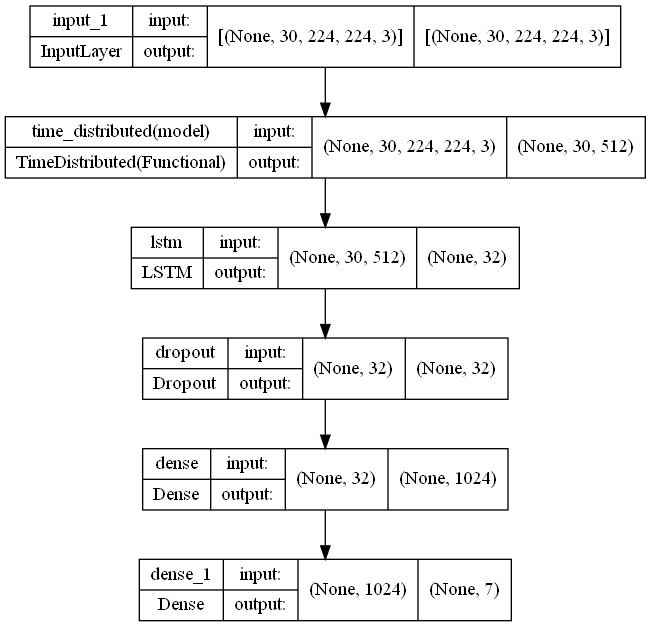

In [9]:
CNN_LSTM_model = create_CNN_LSTM_model()
# Display the success message. 
print("Model Created Successfully!")
print(CNN_LSTM_model.summary())
plot_model(CNN_LSTM_model, to_file = 'vgg16_lstm_model_structure.png', show_shapes = True, show_layer_names = True)

In [10]:
%%time
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

optimizer = 'sgd'
# Compile the model and specify loss function, optimizer and metrics to the model.
CNN_LSTM_model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ["accuracy"])

# Start training the model.
CNN_LSTM_model_training_history = CNN_LSTM_model.fit(x = training_generator, 
    validation_data = validation_generator,
    use_multiprocessing=True,
    workers=4, 
    epochs = 60,
    callbacks = [early_stopping_callback])

Epoch 1/60
197/197 [==============================] - 334s 2s/step - loss: 1.8498 - accuracy: 0.2345 - val_loss: 1.8502 - val_accuracy: 0.1953
Epoch 2/60
197/197 [==============================] - 314s 1s/step - loss: 1.7033 - accuracy: 0.3198 - val_loss: 1.7528 - val_accuracy: 0.3814
Epoch 3/60
197/197 [==============================] - 315s 2s/step - loss: 1.5610 - accuracy: 0.3970 - val_loss: 1.6040 - val_accuracy: 0.3767
Epoch 4/60
197/197 [==============================] - 314s 1s/step - loss: 1.5311 - accuracy: 0.3665 - val_loss: 1.7659 - val_accuracy: 0.4047
Epoch 5/60
197/197 [==============================] - 314s 2s/step - loss: 1.4331 - accuracy: 0.4213 - val_loss: 1.4265 - val_accuracy: 0.4558
Epoch 6/60
197/197 [==============================] - 314s 1s/step - loss: 1.2952 - accuracy: 0.5025 - val_loss: 1.4460 - val_accuracy: 0.4465
Epoch 7/60
197/197 [==============================] - 303s 1s/step - loss: 1.3136 - accuracy: 0.4680 - val_loss: 1.3499 - val_accuracy: 0.4837

In [11]:
print(f"acc: {CNN_LSTM_model_training_history.history['accuracy'][-1]*100:.1f}")
print(f"val_acc: {CNN_LSTM_model_training_history.history['val_accuracy'][-1]*100:.1f}")

acc: 80.1
val_acc: 63.7


In [12]:
%%time
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'VGG_LSTM_model_{optimizer}.h5'
# Save the Model.
CNN_LSTM_model.save(model_file_name)

CPU times: total: 188 ms
Wall time: 272 ms


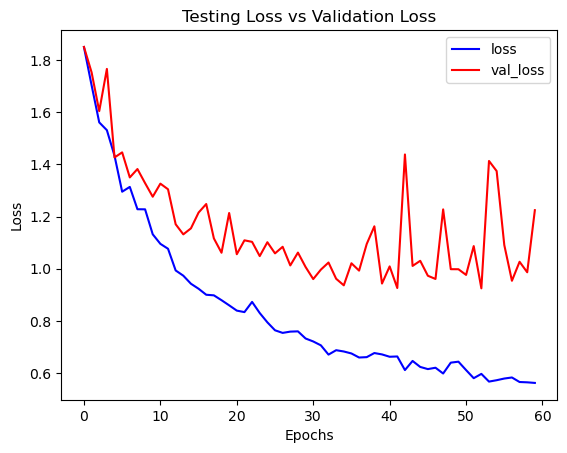

In [13]:
plot_metric(CNN_LSTM_model_training_history, 'loss', 'val_loss', 'Testing Loss vs Validation Loss', 'Loss')

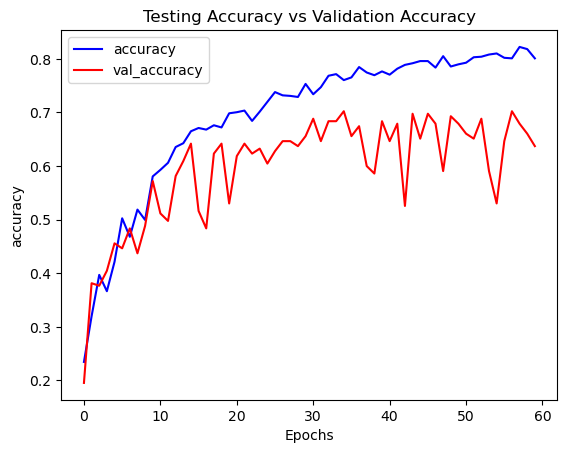

In [14]:
plot_metric(CNN_LSTM_model_training_history, 'accuracy', 'val_accuracy', 'Testing Accuracy vs Validation Accuracy') 

In [17]:
%%time

correct_preds = 0
total = len(nparray_labels["test"].keys())
for file_name in nparray_labels["test"].keys():
	frame = np.load(file_name)
	frame = frame/127.5
	frame -= 1.
	prediction = np.argmax(CNN_LSTM_model.predict(np.array([frame])))
	actual = nparray_labels["test"][file_name]
	if prediction == actual:
		correct_preds += 1
	# print(f'Prediction = {CLASSES_LIST[np.argmax(pred)]}')
	# print(f'Actual = {CLASSES_LIST[nparray_labels["test"]]}')

test_accuracy = correct_preds/total
print(f'Test Accuracy = {test_accuracy}')

Test Accuracy = 0.680365296803653
CPU times: total: 1min 45s
Wall time: 1min 3s


## 3. Create model - (untrained)CNN + LSTM

In [ ]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, DIMENSION_X, DIMENSION_Y, DIMENSION_C)))
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################
    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model
    

In [ ]:
%%time
LRCN_model = create_LRCN_model()
# Display the success message. 
print("Model Created Successfully!")
plot_model(LRCN_model, to_file = 'lrnc_cnn_lstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)


# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = training_generator, 
    validation_data = validation_generator,
    use_multiprocessing=True,
    workers=NR_WORKERS, 
    epochs = NR_EPOCHS,
    callbacks = [early_stopping_callback])

In [ ]:
%%time
model_evaluation_history = LRCN_model.evaluate(x = validation_generator, use_multiprocessing=True, workers=NR_WORKERS)

In [ ]:
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss','Los')

In [ ]:
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

In [ ]:
%%time
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_LSTM_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

## 4. Create model - pre-trained CNN (ResNet50) + LSTM (EXTRA)

In [ ]:
def ResNet_pretrained_model(seq_len=20,frames=30,channels=3,img_height=224,img_width=224,n_output=7):
    frames, channels, rows, columns = frames,channels,img_height,img_width
    video = Input(shape=(frames,rows,columns,channels))
    
    cnn_base = ResNet50(input_shape=(rows,columns, channels),weights="imagenet", include_top=False)
    
    cnn_base.trainable = False

    cnn_out = GlobalAveragePooling2D()(cnn_base.output)
    print(cnn_out)
    
    cnn = Model(cnn_base.input,  cnn_out)
    
    encoded_frames = TimeDistributed(cnn)(video)
    encoded_sequence = LSTM(32)(encoded_frames)
    
    hidden_layer = Dense(1024, activation="relu")(encoded_sequence)
    
    outputs = Dense(n_output, activation="softmax")(hidden_layer)

    model = Model(video, outputs)
    return model

In [ ]:
resnet_model = ResNet_pretrained_model()
# resnet_model.summary()

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
resnet_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
resnet_model = resnet_model.fit(x = training_generator, 
    validation_data = validation_generator,
    use_multiprocessing=True,
    workers=NR_WORKERS, 
    epochs = NR_EPOCHS,
    callbacks = [early_stopping_callback])